In [156]:
# Import dependencies
import pandas as pd
import requests
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as st
import time

from api_key import api_key

In [2]:
# Import data and creat DataFrame
file_path = 'Resources/fastfood.csv'
fast_food_df = pd.read_csv(file_path)

## Data Cleaning

In [3]:
# Update the 'salad' column to True if the substring 'salad' exists in the 'item' column
fast_food_df['salad'] = fast_food_df['item'].str.contains("salad", case=False)

# Drop kids menu items
kids_index = fast_food_df[fast_food_df['item'].str.contains("kids", case=False)].index
fast_food_df = fast_food_df.drop(kids_index)

# Drop 'vit_a', 'vit_c', 'calcium' columns
fast_food_df = fast_food_df[['restaurant', 'item', 'calories', 'cal_fat', 'total_fat', 'sat_fat',
       'trans_fat', 'cholesterol', 'sodium', 'total_carb', 'fiber', 'sugar', 'protein', 'salad']]

fast_food_df = fast_food_df.reset_index(drop=True)
fast_food_df.head()

,restaurant,item,calories,cal_fat,total_fat,sat_fat,trans_fat,cholesterol,sodium,total_carb,fiber,sugar,protein,salad
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380,60,7,2.0,0.0,95,1110,44,3.0,11,37.0,False
1,Mcdonalds,Single Bacon Smokehouse Burger,840,410,45,17.0,1.5,130,1580,62,2.0,18,46.0,False
2,Mcdonalds,Double Bacon Smokehouse Burger,1130,600,67,27.0,3.0,220,1920,63,3.0,18,70.0,False
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750,280,31,10.0,0.5,155,1940,62,2.0,18,55.0,False
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920,410,45,12.0,0.5,120,1980,81,4.0,18,46.0,False


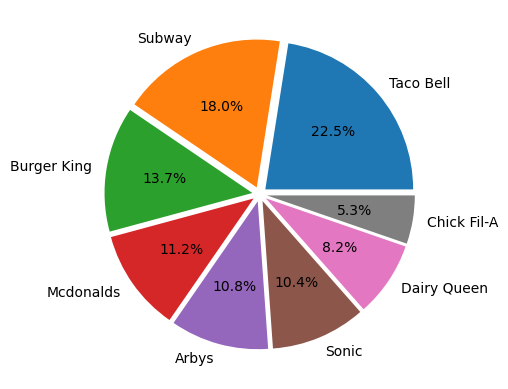

<Figure size 640x480 with 0 Axes>

In [203]:
# Pie Chart of restaurant distribution in cleaned data set

# Set pie chart arguments
x = fast_food_df['restaurant'].value_counts()
labels = x.index
explode = [.05 for _ in range(len(x))]

# Create pie chart
plt.pie(x, labels=labels, explode=explode, autopct='%.1f%%')
plt.show()

# Export image
plt.savefig('Resources/restaurant_pie.png')

## Compare Nutrition to Recipes from API

Using the spoonacular API we will attach a random recipe to a subset of restaurant items with calories per serving within a 5% range of the restaurant item.

From there we will run T-Test for each restaurant to determine if there is a statistical difference between the restaurants average protein, carb or fat values compared to those from the random recipe.

In [4]:
# Copy and Clean Data

# Take only data that is between 500 and 1000 calories
calorie_range_df = fast_food_df[(fast_food_df['calories'] >= 500) & (fast_food_df['calories'] < 1000)]

# Drop Chick Fil-A and Dairy Queen because it does not have enough values in range
calorie_range_df = calorie_range_df[(calorie_range_df['restaurant'] != 'Chick Fil-A') 
                                    & (calorie_range_df['restaurant'] != 'Dairy Queen')]

# Drop unnecessary columns
desired_cols = ['restaurant', 'item', 'calories', 'protein', 'total_fat', 'total_carb']
calorie_range_df = calorie_range_df[desired_cols]

# Drop any other rows that have a NaN value
calorie_range_df = calorie_range_df.dropna(how='any')

# Sort by calories descending and reset index
calorie_range_df = calorie_range_df.sort_values('calories', ascending=False).reset_index(drop=True)

calorie_range_df.head()

,restaurant,item,calories,protein,total_fat,total_carb
0,Burger King,Jalapeno King Sandwich,990,55.0,65,46
1,Burger King,DOUBLE WHOPPER w/ Cheese,990,52.0,65,53
2,Subway,Footlong Turkey Italiano Melt (with Provolone),980,48.0,48,94
3,Arbys,Ultimate BLT,980,43.0,55,80
4,Burger King,Sourdough King Double,970,55.0,61,52


In [5]:
# Loop through cleaned calorie_range_df for an equal distribution of restaurants up to 149 items (max daily API calls)

# Empty list to hold Series objects of loop
item_149 = []

# While we have less that 149 items, loop through each restaurant for new items until 149 is reached
while len(item_149) < 149:
    for restaurant in calorie_range_df['restaurant'].unique():
        if len(item_149) < 149:
            restaurant_df = calorie_range_df[calorie_range_df['restaurant'] == restaurant]
            item_149.append(restaurant_df.iloc[0])
            
            calorie_range_df = calorie_range_df.drop(restaurant_df.iloc[0].name)
            
recipe_comp_df = pd.DataFrame(item_149).reset_index(drop=True)
recipe_comp_df.head()

,restaurant,item,calories,protein,total_fat,total_carb
0,Burger King,Jalapeno King Sandwich,990,55.0,65,46
1,Subway,Footlong Turkey Italiano Melt (with Provolone),980,48.0,48,94
2,Arbys,Ultimate BLT,980,43.0,55,80
3,Sonic,3 Piece Super Crunch Chicken Strip Dinner,970,30.0,46,109
4,Mcdonalds,6 piece Sweet N' Spicy Honey BBQ Glazed Tenders,960,58.0,40,94


In [33]:
# Call the spoonacular API for a random recipe that has similar nutritional criteria
base_url = "https://api.spoonacular.com/recipes/findByNutrients"

# Set params so the API returns 1 random recipe
params = {
    "apiKey": api_key,
    "number": 1,
    "random": "true"
}

# Loop through recipe_comp_df and attach a recipe within the 5% calorie range

for index, row in recipe_comp_df.iterrows():
    # Generate search criteria
    min_cal = int(recipe_comp_df.loc[index,'calories'] * .95)
    max_cal = int(recipe_comp_df.loc[index,'calories'] * 1.05)
    
    # Create a minimum and maximum calorie range and add to params dictionary
    params['minCalories'] = min_cal
    params['maxCalories'] = max_cal
    
    # Make API request
    try:
        recipe = requests.get(base_url, params=params).json()
        time.sleep(1)
    except:
        print(f"API request error at index {index}.")
    
    # Attach recipe data to the DataFrame
    try:
        recipe_comp_df.loc[index, "recipe_name"] = recipe[0]['title']
        recipe_comp_df.loc[index, "recipe_calories"] = recipe[0]['calories']
        recipe_comp_df.loc[index, "recipe_protein"] = int(recipe[0]['protein'].replace('g',''))
        recipe_comp_df.loc[index, "recipe_fat"] = int(recipe[0]['fat'].replace('g',''))
        recipe_comp_df.loc[index, "recipe_carb"] = int(recipe[0]['carbs'].replace('g',''))
        recipe_comp_df.loc[index, "recipe_image"] = recipe[0]['image']
    except:
        print(f"Recipe criteria not found for {row['restaurant']}.")
        
recipe_comp_df.head()

Recipe criteria not found for Burger King.


,restaurant,item,calories,protein,total_fat,total_carb,recipe_name,recipe_calories,recipe_protein,recipe_fat,recipe_carbs,recipe_image
0,Burger King,Jalapeno King Sandwich,990,55.0,65,46,Baked Halibut,960.0,35.0,81.0,12.0,https://spoonacular.com/recipeImages/633638-31...
1,Subway,Footlong Turkey Italiano Melt (with Provolone),980,48.0,48,94,Brown Butter and Sage Ravioli,985.0,33.0,71.0,51.0,https://spoonacular.com/recipeImages/636286-31...
2,Arbys,Ultimate BLT,980,43.0,55,80,Extra Large Homemade Meatballs w Pasta,933.0,53.0,58.0,43.0,https://spoonacular.com/recipeImages/642502-31...
3,Sonic,3 Piece Super Crunch Chicken Strip Dinner,970,30.0,46,109,Lamb & Sweet Potato Pot Pie,961.0,21.0,64.0,64.0,https://spoonacular.com/recipeImages/649178-31...
4,Mcdonalds,6 piece Sweet N' Spicy Honey BBQ Glazed Tenders,960,58.0,40,94,Pork tenderloin in puff pastry,933.0,43.0,62.0,46.0,https://spoonacular.com/recipeImages/1095801-3...


In [38]:
# Save the combined fast food and random recipe DataFrame as a csv
recipe_comp_df.to_csv('Resources/recipe_comp.csv')

In [126]:
# Create a two-tailed T-Test analyzing each restaurant's nutrient against random recipes

# Create a dictionary that we will convert to a DataFrame once loop complete
restaurant_list = recipe_comp_df['restaurant'].unique()
t_test_dict = {
    'restaurant': restaurant_list,
    'protein': [],
    'fat': [],
    'carb': []
}

# Loop through each restaurant and run T-Test for each nutrient type
for restaurant in restaurant_list:
    
    # Isolate the restaurant within the DataFrame
    rest_df = recipe_comp_df[recipe_comp_df['restaurant'] == restaurant]
    
    # Run T-Test for each nutrient
    for nutrient in ['protein', 'fat', 'carb']:
        if nutrient == 'protein':
            ff_col = nutrient
        else:
            ff_col = 'total_' + nutrient
            
        recipe_col = 'recipe_' + nutrient
        
        # Save a variable for the fast food and recipe sample
        ff_sample = rest_df[ff_col]
        recipe_sample = rest_df[recipe_col]
        
        # Run T-Test and save p-value
        nutrient_p = st.ttest_ind(ff_sample, recipe_sample, equal_var=False)[1]
        
        # Add the p-value to the appropriate list in the dictionary
        t_test_dict[nutrient].append(nutrient_p)
        
# Create a DataFrame from the dictionary containing the results of the two-tailed T-Tests
t_test_df = pd.DataFrame(t_test_dict).set_index('restaurant', drop=True)
t_test_df

,protein,fat,carb
restaurant,,,
Burger King,0.448409,0.040946,0.087116
Subway,0.001172,0.000036,0.000022
Arbys,0.707794,0.683651,0.064054
Sonic,0.693465,0.190338,0.842449
Mcdonalds,0.966352,0.922478,0.119826
Taco Bell,0.135933,0.216930,0.000778


## Restaurant Analysis Tool
This tool allows the user to select the restaurant, nutrient, and T-Test alternative (two-tailed vs. one-tailed).

In [201]:
# Create a function that allows the user to customize inputs

def nutrition_recipe_analysis(df):
    # Print input options for restaurant
    print("Restaurant Options")
    print('-'*20)
    print("1 - Burger King")
    print("2 - Subway")
    print("3 - Arbys")
    print("4 - Sonic")
    print("5 - Mcdonalds")
    print("6 - Taco Bell")
    print('-'*20)
    
    # Gather and convert restaurant input with error handling
    rest_pick = 0
    while rest_pick not in range(1,7):
        try:
            rest_pick = int(input("Enter the number for the restaurant you'd like to view: "))
            if rest_pick not in range(1,7):
                rest_pick = int(input("Entry is out of range. Please try again: "))
        except:
            rest_pick = int(input("Entry is not an integer. Please try again: "))
        
        
    if rest_pick == 1:
        restaurant = 'Burger King'
    elif rest_pick == 2:
        restaurant = 'Subway'
    elif rest_pick == 3:
        restaurant = 'Arbys'
    elif rest_pick == 4:
        restaurant = 'Sonic'
    elif rest_pick == 5:
        restaurant = 'Mcdonalds'
    elif rest_pick == 6:
        restaurant = 'Taco Bell'
    
    print(f'You chose: {restaurant.upper()}')
    print('')
        
    # Create a DataFrame for only the selected restaurant
    df = df[df['restaurant'] == restaurant]
    
    # Print options for nutrient
    print("Nutrient Options")
    print('-'*20)
    print("1 - protein")
    print("2 - fat")
    print("3 - carb")
    print('-'*20)
    
    # Gather and convert nutrient input with error handling
    nut_pick = 0
    while nut_pick not in range(1,4):
        try:
            nut_pick = int(input("Enter the number for the nutrient you'd like to view: "))
            if nut_pick not in range(1,4):
                nut_pick = int(input("Entry is out of range. Please try again: "))
        except:
            nut_pick = int(input("Entry is not an integer. Please try again: "))
    
    # Assign columns based on 
    if nut_pick == 1:
        nutrient = 'protein'
    elif nut_pick == 2:
        nutrient = 'fat'
    elif nut_pick == 3:
        nutrient = "carb"
    # Handle protien column differently than others
    if nutrient == 'protein':
        ff_col = nutrient
    else:
        ff_col = 'total_' + nutrient
        
    recipe_col = 'recipe_' + nutrient
    
    print(f"you chose: {nutrient.upper()}")
    print('')
    
    # Print input options for restaurant
    print("T-Test Alternative Hypothesis Options")
    print('-'*20)
    print(f"1 - {restaurant}'s average {nutrient} is GREATER THAN the average {nutrient} from random recipes with similar calories.")
    print(f"2 - {restaurant}'s average {nutrient} is LESS THAN the average {nutrient} from random recipes with similar calories.")
    print(f"3 - {restaurant}'s average {nutrient} is NOT EQUAL TO the average {nutrient} from random recipes with similar calories.")
    print('-'*20)
    
    # Gather and convert T-Test input with error handling
    t_pick = 0
    while t_pick not in range(1,4):
        try:
            t_pick = int(input("Enter the number for the T-Test you'd like to view: "))
            if t_pick not in range(1,4):
                t_pick = int(input("Entry is out of range. Please try again: "))
        except:
            t_pick = int(input("Entry is not an integer. Please try again: "))
        
    if t_pick == 1:
        alt = 'greater'
    elif t_pick == 2:
        alt = 'less'
    elif t_pick == 3:
        alt = 'two-sided'
    
    print(f"you chose: {alt.upper()}")
    print('')
    
    # Run T-Test based on inputs and save p-value
    p_val = st.ttest_ind(df[ff_col], df[recipe_col], equal_var=False, alternative=alt)[1]
    
    # Display averages, alpha, and p-value from T-Test
    print("T-Test Output")
    print('-'*20)
    print(f"{restaurant} average {nutrient}: {df[ff_col].mean()}")
    print(f"Random recipe average {nutrient}: {df[recipe_col].mean()}")
    print(f"alpha: 0.05")
    print(f"p-value: {p_val}")
    print('-'*20)
    
    # Pring null hypothesis outcome
    if p_val < .05:
        print("REJECT THE NULL HYPOTHESIS")
    else: 
        print('FAIL TO REJECT THE NULL HYPOTHESIS')
        
    # Create the plot     
    bins = range(0, 100, 10)
    plt.hist(df[ff_col], bins, alpha=.5, label=restaurant)
    plt.hist(df[recipe_col], bins, alpha=.5, label='Recipe')
    plt.title(f"{nutrient.title()} Histogram ({restaurant} and Random Recipe)")
    plt.xlabel(f"{nutrient.title()} (grams)")
    plt.ylabel('Frequency')
    plt.xticks(bins)
    plt.legend(loc='best')
    plt.show()

In [202]:
# Create script to run analysis until use it satisfied
analysis = 'yes'
while analysis == 'yes':
    nutrition_recipe_analysis(recipe_comp_df)
    analysis = input("Enter 'yes' if you'd like to run another nutrition analysis: ").lower()

Restaurant Options
--------------------
1 - Burger King
2 - Subway
3 - Arbys
4 - Sonic
5 - Mcdonalds
6 - Taco Bell
--------------------
Enter the number for the restaurant you'd like to view: h
Entry is not an integer. Please try again: 5
You chose: MCDONALDS

Nutrient Options
--------------------
1 - protein
2 - fat
3 - carb
--------------------
Enter the number for the nutrient you'd like to view: you
Entry is not an integer. Please try again: 3
you chose: CARB

T-Test Alternative Hypothesis Options
--------------------
1 - Mcdonalds's average carb is GREATER THAN the average carb from random recipes with similar calories.
2 - Mcdonalds's average carb is LESS THAN the average carb from random recipes with similar calories.
3 - Mcdonalds's average carb is NOT EQUAL TO the average carb from random recipes with similar calories.
--------------------
Enter the number for the T-Test you'd like to view: pls
Entry is not an integer. Please try again: b


ValueError: invalid literal for int() with base 10: 'b'